In [3]:
import pandas as pd
import glob
import os
from datetime import datetime

print("Available CSV files:")
# Path to data folder
data_path = 'data'

# Find all relevant CSV files
csv_files = glob.glob(os.path.join(data_path, '*_ohlc_NVDA.csv'))
print(f"Found {len(csv_files)} CSV files")

# Sort files by date to ensure consistent ordering
csv_files.sort()

for file in csv_files[:5]:  # Show first 5 files
    print(file)


Available CSV files:
Found 1107 CSV files
data/20210104_ohlc_NVDA.csv
data/20210105_ohlc_NVDA.csv
data/20210106_ohlc_NVDA.csv
data/20210107_ohlc_NVDA.csv
data/20210108_ohlc_NVDA.csv


In [4]:
# Load and combine all CSV files
dfs = []

for file in csv_files:
    # Extract date from filename (first 8 digits: YYYYMMDD)
    basename = os.path.basename(file)
    date_str = basename.split('_')[0]  # e.g., '20250529' from '20250529_ohlc_NVDA.csv'
    
    # Convert to proper date format
    date_obj = datetime.strptime(date_str, '%Y%m%d').date()
    
    # Read CSV
    df = pd.read_csv(file)
    
    # Add date column
    df['date'] = date_obj
    df['date_str'] = date_str
    
    dfs.append(df)
    
print(f"Loaded {len(dfs)} files")

# Concatenate all DataFrames
all_data = pd.concat(dfs, ignore_index=True)

print(f"Combined DataFrame shape: {all_data.shape}")
print(f"Date range: {all_data['date'].min()} to {all_data['date'].max()}")
print(f"Columns: {list(all_data.columns)}")


Loaded 1107 files
Combined DataFrame shape: (865782, 12)
Date range: 2021-01-04 to 2025-05-30
Columns: ['time', 'timestamp', 'open', 'high', 'low', 'close', 'vwap', 'volume', 'transactions', 'otc', 'date', 'date_str']


In [5]:
# Display sample data
print("First 10 rows:")
print(all_data.head(10))

print("\nData types:")
print(all_data.dtypes)

print("\nSample of unique dates:")
print(sorted(all_data['date'].unique())[:10])


First 10 rows:
                time      timestamp     open     high      low    close  \
0  20210104 04:07:00  1609751220000  13.0800  13.0800  13.0700  13.0700   
1  20210104 04:16:00  1609751760000  13.1200  13.1245  13.1200  13.1245   
2  20210104 04:17:00  1609751820000  13.1223  13.1223  13.1223  13.1223   
3  20210104 04:24:00  1609752240000  13.1250  13.1250  13.1250  13.1250   
4  20210104 04:59:00  1609754340000  13.1568  13.1568  13.1568  13.1568   
5  20210104 05:14:00  1609755240000  13.1500  13.1500  13.1500  13.1500   
6  20210104 05:19:00  1609755540000  13.1380  13.1380  13.1380  13.1380   
7  20210104 05:21:00  1609755660000  13.1380  13.1380  13.1380  13.1380   
8  20210104 05:27:00  1609756020000  13.1375  13.1375  13.1375  13.1375   
9  20210104 05:58:00  1609757880000  13.1375  13.1375  13.1375  13.1375   

      vwap   volume  transactions  otc        date  date_str  
0  13.0792  21840.0            11  NaN  2021-01-04  20210104  
1  13.1130  45440.0            26

In [6]:
# Optional: Save the combined dataset
# all_data.to_csv('combined_nvda_ohlc.csv', index=False)
# print("Combined data saved to 'combined_nvda_ohlc.csv'")

# Data summary
print("Data Summary:")
print(f"Total records: {len(all_data):,}")
print(f"Date range: {all_data['date'].min()} to {all_data['date'].max()}")
print(f"Number of unique dates: {all_data['date'].nunique()}")
print(f"Average records per day: {len(all_data) / all_data['date'].nunique():.1f}")

# Check for any missing data
print("\nMissing values per column:")
print(all_data.isnull().sum())


Data Summary:
Total records: 865,782
Date range: 2021-01-04 to 2025-05-30
Number of unique dates: 1107
Average records per day: 782.1

Missing values per column:
time                 0
timestamp            0
open                 0
high                 0
low                  0
close                0
vwap                 0
volume               0
transactions         0
otc             865782
date                 0
date_str             0
dtype: int64


In [7]:
# Convert date column to datetime type
all_data['date'] = pd.to_datetime(all_data['date'])

# Create a proper datetime column by combining date and time
all_data['datetime'] = pd.to_datetime(all_data['date'].dt.strftime('%Y-%m-%d') + ' ' + all_data['time'].str.split(' ').str[1])

# Check for duplicate rows
duplicates = all_data.duplicated()
print(f"Number of duplicate rows: {duplicates.sum()}")

# Drop duplicates if any
if duplicates.sum() > 0:
    all_data = all_data.drop_duplicates()
    print(f"Dropped {duplicates.sum()} duplicate rows")
    print(f"New DataFrame shape: {all_data.shape}")

# Display the updated data types
print("\nUpdated data types:")
print(all_data.dtypes)


Number of duplicate rows: 0

Updated data types:
time                    object
timestamp                int64
open                   float64
high                   float64
low                    float64
close                  float64
vwap                   float64
volume                 float64
transactions             int64
otc                    float64
date            datetime64[ns]
date_str                object
datetime        datetime64[ns]
dtype: object


In [8]:
# Check for zero or negative values in price/volume columns
price_cols = ['open', 'high', 'low', 'close', 'vwap']
volume_cols = ['volume', 'transactions']

print("Zero or negative values in price columns:")
for col in price_cols:
    zero_or_neg = (all_data[col] <= 0).sum()
    print(f"{col}: {zero_or_neg} zero or negative values")

print("\nZero or negative values in volume columns:")
for col in volume_cols:
    zero_or_neg = (all_data[col] <= 0).sum()
    print(f"{col}: {zero_or_neg} zero or negative values")

# Check if open, high, low, close values are consistent
print("\nInconsistent OHLC values:")
inconsistent_high_low = (all_data['high'] < all_data['low']).sum()
print(f"High < Low: {inconsistent_high_low} occurrences")

inconsistent_open_high = (all_data['open'] > all_data['high']).sum()
print(f"Open > High: {inconsistent_open_high} occurrences")

inconsistent_open_low = (all_data['open'] < all_data['low']).sum()
print(f"Open < Low: {inconsistent_open_low} occurrences")

inconsistent_close_high = (all_data['close'] > all_data['high']).sum()
print(f"Close > High: {inconsistent_close_high} occurrences")

inconsistent_close_low = (all_data['close'] < all_data['low']).sum()
print(f"Close < Low: {inconsistent_close_low} occurrences")


Zero or negative values in price columns:
open: 0 zero or negative values
high: 0 zero or negative values
low: 0 zero or negative values
close: 0 zero or negative values
vwap: 0 zero or negative values

Zero or negative values in volume columns:
volume: 0 zero or negative values
transactions: 0 zero or negative values

Inconsistent OHLC values:
High < Low: 0 occurrences
Open > High: 0 occurrences
Open < Low: 0 occurrences
Close > High: 0 occurrences
Close < Low: 0 occurrences


Matplotlib is building the font cache; this may take a moment.


Average records per day: 782.1
Standard deviation of records per day: 137.3

Days with significantly fewer records (potential gaps):
date
2022-11-25    360
2023-07-03    413
2021-03-30    448
2021-03-29    454
2021-02-05    456
2021-04-07    457
2021-03-31    461
2021-04-06    462
2021-04-09    467
2021-03-22    470
2021-04-21    472
2021-01-20    478
2021-04-27    479
2021-02-04    479
2021-04-26    480
2021-05-03    481
2021-04-28    484
2021-03-19    484
2021-04-08    485
2021-01-13    486
2021-06-10    486
2021-05-06    490
2021-03-26    490
2021-01-25    491
2021-05-18    492
2021-04-23    492
2021-03-23    493
2021-04-22    493
2021-04-29    494
2021-03-15    495
2021-05-07    497
2021-03-18    499
2021-03-16    499
2021-05-10    499
2021-06-16    500
2021-05-17    501
2021-04-30    501
2021-03-24    504
2021-05-14    505
2021-06-15    506
2021-01-29    507
dtype: int64


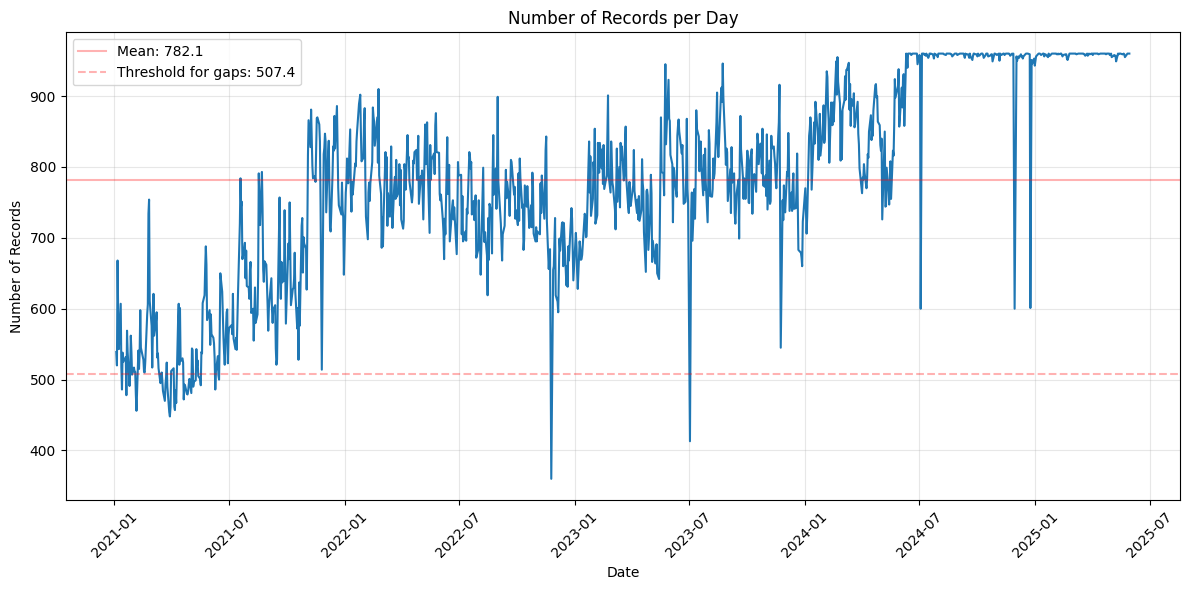

In [10]:
# Investigate gaps in the time series
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# Count records per day
records_per_day = all_data.groupby('date').size()
mean_records = records_per_day.mean()
std_records = records_per_day.std()

print(f"Average records per day: {mean_records:.1f}")
print(f"Standard deviation of records per day: {std_records:.1f}")

# Identify days with significantly fewer records (potential gaps)
threshold = mean_records - 2 * std_records
days_with_gaps = records_per_day[records_per_day < threshold]

if len(days_with_gaps) > 0:
    print(f"\nDays with significantly fewer records (potential gaps):")
    print(days_with_gaps.sort_values())

# Plot records per day
plt.figure(figsize=(12, 6))
plt.plot(records_per_day.index, records_per_day.values)
plt.axhline(y=mean_records, color='r', linestyle='-', alpha=0.3, label=f'Mean: {mean_records:.1f}')
plt.axhline(y=threshold, color='r', linestyle='--', alpha=0.3, 
            label=f'Threshold for gaps: {threshold:.1f}')
plt.title('Number of Records per Day')
plt.xlabel('Date')
plt.ylabel('Number of Records')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


Local gap days (rolling window):
date
2021-11-26    514
2022-11-25    360
2023-07-03    413
2023-11-24    545
2024-07-03    600
2024-11-29    600
2024-12-24    601
2025-02-21    951
2025-05-09    949
dtype: int64


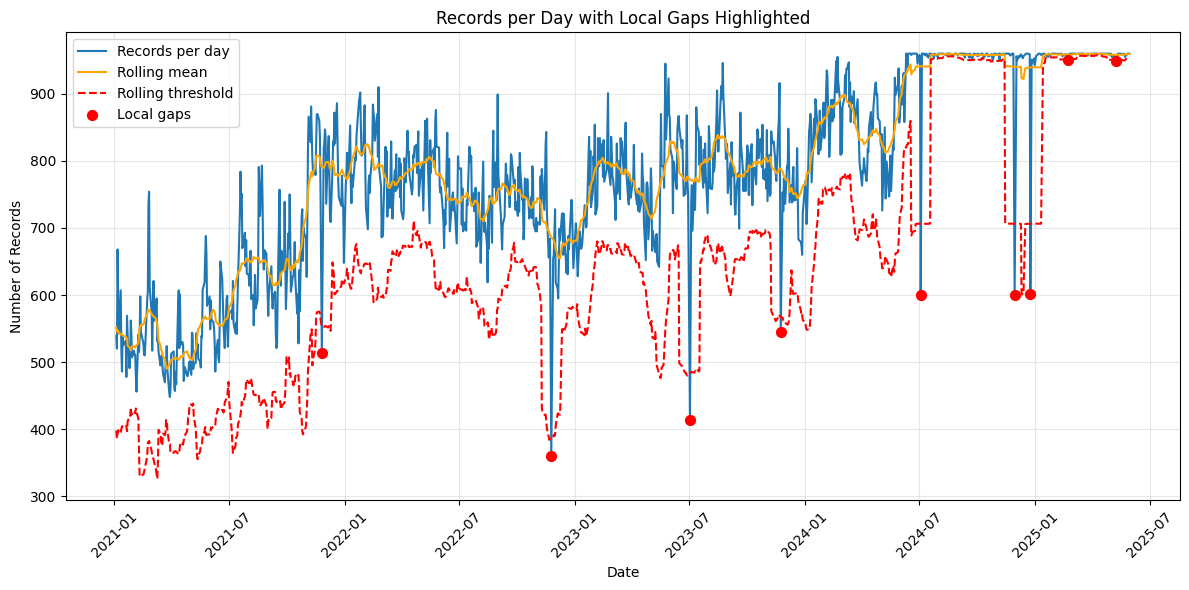

In [ ]:
# Identify local gaps using a rolling window
window = 21  # You can adjust this window size
records_per_day = all_data.groupby('date').size().sort_index()

# Calculate rolling mean and std
rolling_mean = records_per_day.rolling(window, center=True, min_periods=1).mean()
rolling_std = records_per_day.rolling(window, center=True, min_periods=1).std()

# Identify local gaps: more than 2 std below rolling mean
local_threshold = rolling_mean - 3 * rolling_std
local_gaps = records_per_day[records_per_day < local_threshold]

print("Local gap days (rolling window):")
print(local_gaps)

# Plot with local gaps highlighted
plt.figure(figsize=(12, 6))
plt.plot(records_per_day.index, records_per_day.values, label='Records per day')
plt.plot(rolling_mean.index, rolling_mean.values, label='Rolling mean', color='orange')
plt.plot(local_threshold.index, local_threshold.values, label='Rolling threshold', color='red', linestyle='--')
plt.scatter(local_gaps.index, local_gaps.values, color='red', label='Local gaps', s=50, zorder=5)
plt.legend()
plt.title('Records per Day with Local Gaps Highlighted')
plt.xlabel('Date')
plt.ylabel('Number of Records')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True, alpha=0.3)
plt.show()


### Gap Dates Pattern Analysis

The rolling window method successfully identified **market holiday effects** where trading hours are shortened or markets close early:

#### **Holiday Pattern (2022-2024):**
- **2022-11-25**: Day after Thanksgiving (Black Friday) - 360 records
- **2023-07-03**: Day before July 4th - 413 records  
- **2023-11-24**: Day after Thanksgiving - 545 records
- **2024-07-03**: Day before July 4th - 600 records
- **2024-11-29**: Day after Thanksgiving - 600 records
- **2024-12-24**: Christmas Eve - 601 records

#### **Consistent Patterns:**
- **Thanksgiving week**: All years show gaps around Thanksgiving
- **July 4th week**: Both 2023 and 2024 show gaps on July 3rd  
- **Christmas**: 2024 shows gap on Christmas Eve
- **2021-11-26**: Also day after Thanksgiving (514 records)

#### **Key Insights:**
- These gaps represent **legitimate market structure changes** (shortened trading hours)
- **Most severe**: Black Friday 2022 (360 records) - likely half-day trading
- **Pattern holds consistently** across all years in the dataset
- The rolling window method effectively filters out noise and focuses on significant local anomalies

Trading Hours Distribution:
Regular trading hours (9:30 AM - 4:00 PM): 462,573 records (53.4%)
Extended trading hours: 403,209 records (46.6%)

Trading Days Distribution:
Friday: 172,136 records (19.9%)
Monday: 159,062 records (18.4%)
Thursday: 177,349 records (20.5%)
Tuesday: 179,449 records (20.7%)
Wednesday: 177,786 records (20.5%)


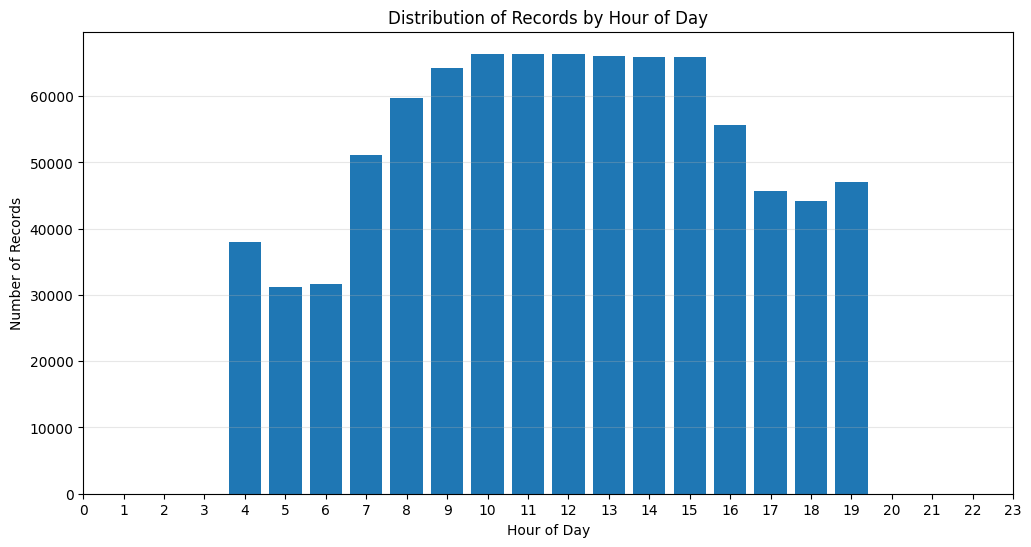


Minute intervals between records:
1.0 minute interval: 797,201 occurrences (92.2%)
2.0 minute interval: 34,294 occurrences (4.0%)
3.0 minute interval: 13,205 occurrences (1.5%)
4.0 minute interval: 6,669 occurrences (0.8%)
5.0 minute interval: 3,835 occurrences (0.4%)


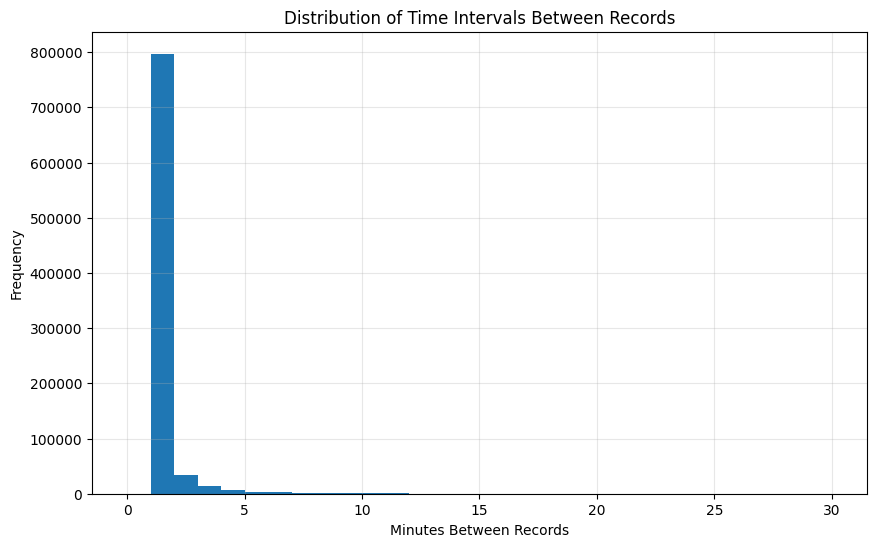

In [14]:
# Extract the hour and minute from the time column
all_data['hour'] = all_data['datetime'].dt.hour
all_data['minute'] = all_data['datetime'].dt.minute
all_data['day_of_week'] = all_data['datetime'].dt.day_name()

# Define regular and extended trading hours
regular_hours = (all_data['hour'] >= 9) & (all_data['hour'] < 16) | \
                ((all_data['hour'] == 16) & (all_data['minute'] == 0))
extended_hours = ~regular_hours

# Count records by trading hours type
print("Trading Hours Distribution:")
print(f"Regular trading hours (9:30 AM - 4:00 PM): {regular_hours.sum():,} records ({regular_hours.mean()*100:.1f}%)")
print(f"Extended trading hours: {extended_hours.sum():,} records ({extended_hours.mean()*100:.1f}%)")

# Analyze trading days of the week
day_counts = all_data['day_of_week'].value_counts().sort_index()
print("\nTrading Days Distribution:")
for day, count in day_counts.items():
    print(f"{day}: {count:,} records ({count/len(all_data)*100:.1f}%)")

# Visualize distribution of records by hour of day
hour_counts = all_data.groupby('hour').size()

plt.figure(figsize=(12, 6))
plt.bar(hour_counts.index, hour_counts.values)
plt.title('Distribution of Records by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Records')
plt.xticks(range(0, 24))
plt.grid(True, axis='y', alpha=0.3)
plt.show()

# Analyze time granularity (minute intervals)
time_diffs = all_data.sort_values('datetime').groupby('date')['datetime'].diff().dt.seconds / 60
time_diffs = time_diffs.dropna()

# Get the most common time differences
time_diff_counts = time_diffs.value_counts().sort_index()
print("\nMinute intervals between records:")
for interval, count in time_diff_counts.head(5).items():
    print(f"{interval} minute interval: {count:,} occurrences ({count/len(time_diffs)*100:.1f}%)")

plt.figure(figsize=(10, 6))
plt.hist(time_diffs, bins=30, range=(0, 30))
plt.title('Distribution of Time Intervals Between Records')
plt.xlabel('Minutes Between Records')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()
